# Project #3 – Human Activity Recognition
---

### Michael Mars, 2023

#### Basic imports

In [76]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from collections import Counter
from matplotlib import pyplot as plt

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers.core import Dense, Dropout
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [77]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#### Retrieve features and activity subjects

In [78]:
# check the features from the file features.txt
def get_features():
    features = list()
    with open('UCI HAR Dataset/features.txt') as f:
        features = [line.split()[1] for line in f.readlines()]
    print(f'No of Features: {len(features)}')
    return features
get_features()

# Get unique subject IDs
subjects = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None, delim_whitespace=True).to_numpy()
subjects = np.squeeze(subjects)
print('subjects:', np.unique(subjects))

No of Features: 561
subjects: [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


Not all subjects are given: subjects 2, 4, 9, 10, etc. are missing.

## Load data from raw files

In [79]:
# Signals are from accelerometer and gyroscope, in x,y,z directions
# Total acceleration is triaxial acceleration from the accelerometer

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [80]:
# Load signal files into dataframes, filtered by 'train' or 'test'

def load_signals(subset):
    signal_data = []

    for signal in SIGNALS:
        filename = f'UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        sig_df = pd.read_csv(filename, header=None, delim_whitespace=True)
        print(f'loaded file {filename} - shape: {sig_df.shape}')
        print(f'\nDuplicates in sig_df: {sum(sig_df.duplicated())}')
        print()
        signal_data.append(sig_df)
        # signals_data[signal] = sig_df

    return signal_data

In [81]:
# Load activity labels, filtered by 'train' or 'test'

def load_y(subset):
    filename = f'UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = pd.read_csv(filename, delim_whitespace=True, header=None)[0]
    return y

Serialize the loaded data into pickles and numpy npz for saving future loading time  

For data exploration and deep model, data is loaded into both dataframes and numpy 3D arrays  

Since our data is multivariate time series, it shall be put it into 3D numpy arrays in **[samples, timesteps, features]** format for LSTM deep model


In [82]:
import pickle
from sklearn import preprocessing as pre


def normalize_2D(X):
    scaler = pre.StandardScaler().set_output(transform="pandas")
    X_norm = scaler.fit_transform(X)
    # X_norm_2d = pre.MinMaxScaler(feature_range=(-1,1)).fit_transform(X_2D)
    # Fit the scaler to the data and transform the data
    # X_normalized_2d = (X_2d - np.min(X_2d)) / (np.max(X_2d) - np.min(X_2d))
    return X_norm


def load_data(normalize=False):
    X_train, X_test, X_train_3D, X_test_3D, y_train, y_test = None, None, None, None, None, None

    # load data from saved pickles if exist
    if os.path.isfile('data/X_train.pkl'):
        with open('data/X_train.pkl', 'rb') as f:
            X_train = pickle.load(f)
        with open('data/X_test.pkl', 'rb') as f:
            X_test = pickle.load(f)

        # X_train = pd.read_pickle('data/X_train.pkl.zip')
        # X_test  = pd.read_pickle('data/X_test.pkl.zip')
        y_train = pd.read_pickle('data/y_train.pkl.zip')
        y_test  = pd.read_pickle('data/y_test.pkl.zip')
        # return X_train, X_test, y_train, y_test

    if os.path.isfile('data/data.npz'):
        loaded = np.load('data/data.npz')
        X_train_3D = loaded['x_train']
        X_test_3D = loaded['x_test']
        return X_train, X_test, X_train_3D, X_test_3D, y_train, y_test


    # ELSE

    # load data into 2D dataframes for all 9 signals
    X_train, X_test = load_signals('train'), load_signals('test')

    if normalize:
        for i in range(len(X_train)):
            X_train[i] = normalize_2D(X_train[i])
            X_test[i]  = normalize_2D(X_test[i]) 


    # X_train = pd.concat(X_train_d.values(), axis=1, ignore_index=True)
    # X_test = pd.concat(X_test_d.values(), axis=1, ignore_index=True)

    # This data is multivariate time series, hence shall be put into 3D numpy arrays in [samples, timesteps, features] format for LSTM deep model
    X_train_3D = np.dstack([data.values for data in X_train])
    X_test_3D  = np.dstack([data.values for data in X_test])

    y_train, y_test = load_y('train'), load_y('test')

    os.makedirs('data', exist_ok=True)
    with open('data/X_train.pkl', 'wb') as f:
        pickle.dump(X_train, f)
    with open('data/X_test.pkl', 'wb') as f:
        pickle.dump(X_test, f)

    # X_train.to_pickle('data/X_train.pkl.zip', compression='zip')
    # X_test.to_pickle('data/X_test.pkl.zip', compression='zip')
    y_train.to_pickle('data/y_train.pkl.zip', compression='zip')
    y_test.to_pickle('data/y_test.pkl.zip', compression='zip')
    np.savez_compressed('data/data', x_train=X_train_3D, x_test=X_test_3D)
    return X_train, X_test, X_train_3D, X_test_3D, y_train, y_test


# used for testing:
# X_train, X_test, X_train_3D, X_test_3D, y_train, y_test = load_data()
# print(X_train.shape)
# print(X_train_3D.shape)
# print(y_train.shape)

### Load the train and test data 

See distibution of the activity labels

loaded file UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt - shape: (7352, 128)

Duplicates in sig_df: 0

loaded file UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt - shape: (7352, 128)

Duplicates in sig_df: 0

loaded file UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt - shape: (7352, 128)

Duplicates in sig_df: 0

loaded file UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt - shape: (7352, 128)

Duplicates in sig_df: 0

loaded file UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt - shape: (7352, 128)

Duplicates in sig_df: 0

loaded file UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt - shape: (7352, 128)

Duplicates in sig_df: 0

loaded file UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt - shape: (7352, 128)

Duplicates in sig_df: 0

loaded file UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt - shape: (7352, 128)

Duplicates in sig_df: 0

loaded file UCI HAR Dataset/train/Inertial 

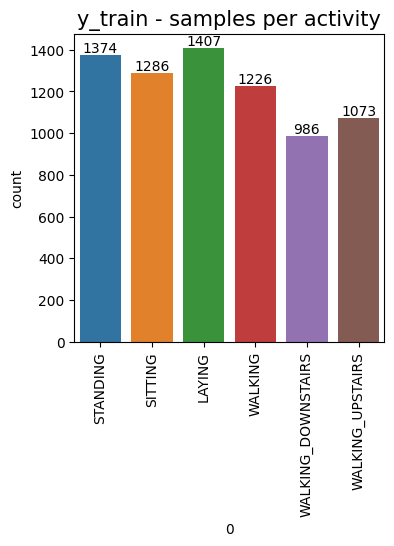

col_0,count
0,
LAYING,1407
SITTING,1286
STANDING,1374
WALKING,1226
WALKING_DOWNSTAIRS,986
WALKING_UPSTAIRS,1073


In [83]:
X_train, X_test, X_train_3D, X_test_3D, y_train, y_test = load_data()

print()
print('X_train: ', len(X_train), 'X', X_train[0].shape)
print('X_test: ', len(X_test), 'X', X_test[0].shape)

print('\nX_train_3D shape:', X_train_3D.shape)
print('X_test_3D shape:', X_test_3D.shape)

print('\nX_train_3D stats - min-mean-max:')
print(np.min(X_train_3D), np.mean(X_train_3D), np.max(X_train_3D))


print('\ny_train shape:', y_train.shape)
print(Counter(y_train))
print(y_train.value_counts(normalize=True))

print('\ny_test shape:', y_test.shape)
print(Counter(y_test))
print(y_test.value_counts(normalize=True))
print()


ACTIVITIES_MAP = {1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS', 4:'SITTING', 5:'STANDING',6:'LAYING'}
y_train_labels = y_train.map(ACTIVITIES_MAP)
          
plt.figure(figsize=(4,4))        
plt.title('y_train - samples per activity', fontsize=15)
ax = sns.countplot(x=y_train_labels)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

pd.crosstab(index=pd.Series(y_train_labels), columns="count")

Naturally, we see more samples for static activities: Standing, Sitting and Laying.

1 - WALKING 1226
(1226, 128, 9)
(1226, 9)
2 - WALKING_UPSTAIRS 1073
(1073, 128, 9)
(1073, 9)
3 - WALKING_DOWNSTAIRS 986
(986, 128, 9)
(986, 9)
4 - SITTING 1286
(1286, 128, 9)
(1286, 9)
5 - STANDING 1374
(1374, 128, 9)
(1374, 9)
6 - LAYING 1407
(1407, 128, 9)
(1407, 9)


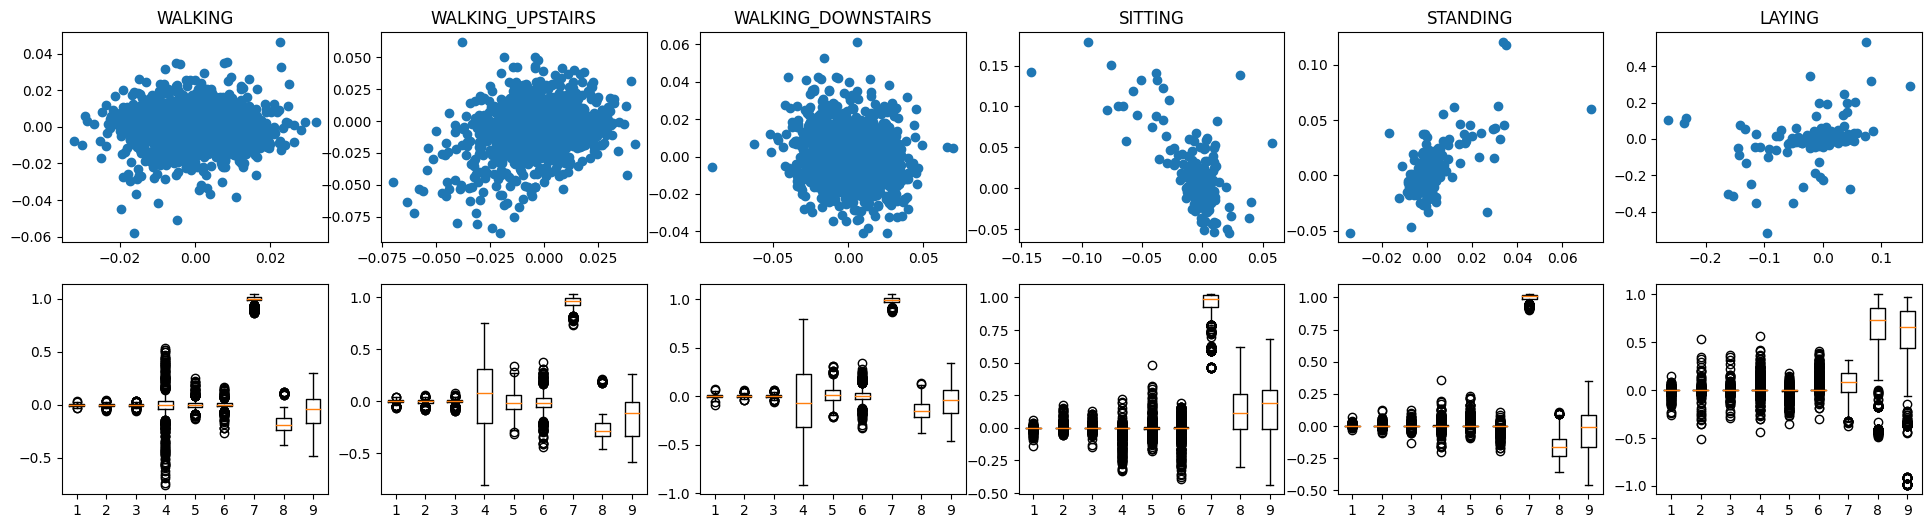

<Figure size 700x500 with 0 Axes>

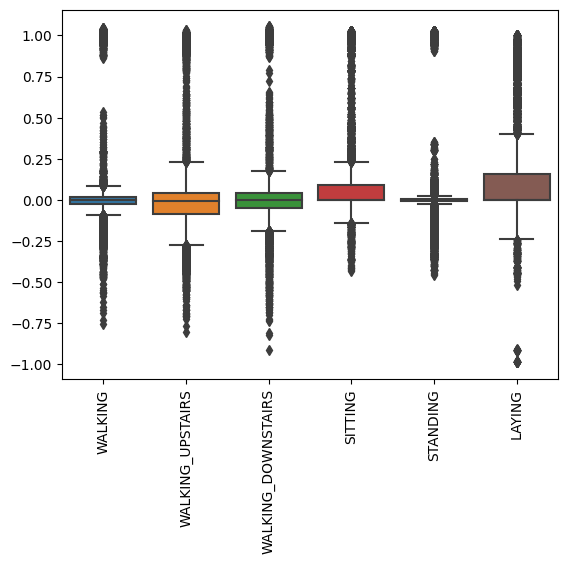

In [84]:
def group_indices_by_label(y):
    labels = np.unique(y)
    indices_by_label = {}
    for label in labels:
        indices_by_label[label] = np.where(y == label)[0]
    return indices_by_label

ind_by_label = group_indices_by_label(y_train)


mean_by_labels = {}

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(24, 6))

for l in ind_by_label.keys():
    print(l, '-', ACTIVITIES_MAP[l], len(ind_by_label[l]))

    X_act = X_train_3D[ind_by_label[l]]   # X_flat = X.flatten()
    print(X_act.shape)

    mean_per_sample_per_feature = np.mean(X_act, axis=1)
    print(mean_per_sample_per_feature.shape)
    
    mean_by_labels[ACTIVITIES_MAP[l]] = mean_per_sample_per_feature.flatten()

    # Create scatter plots
    ax[0, l-1].set_title(f'{ACTIVITIES_MAP[l]}')
    ax[0, l-1].scatter(mean_per_sample_per_feature[:,0], mean_per_sample_per_feature[:,1])

    # Create box plots
    ax[1, l-1].boxplot(mean_per_sample_per_feature)


plt.figure(figsize=(7,5))
fig, ax = plt.subplots()
sns.boxplot(list(mean_by_labels.values()))
ax.set_xticklabels(mean_by_labels.keys())
plt.xticks(rotation=90)
plt.show()


[-0.00429425 -0.01261049 -0.03300622 -0.00386222 -0.00902159 -0.00689051
  1.012817   -0.132631    0.08874205]
[ 0.00226869 -0.00165537 -0.00812555  0.02225035  0.01940277  0.00946815
  1.01930457 -0.12426187  0.09973179]
[ 0.01081025  0.01076681  0.05556068  0.05054452  0.07485018  0.02285864
  1.024606   -0.1172102   0.109485  ]

min - mean - max  plot


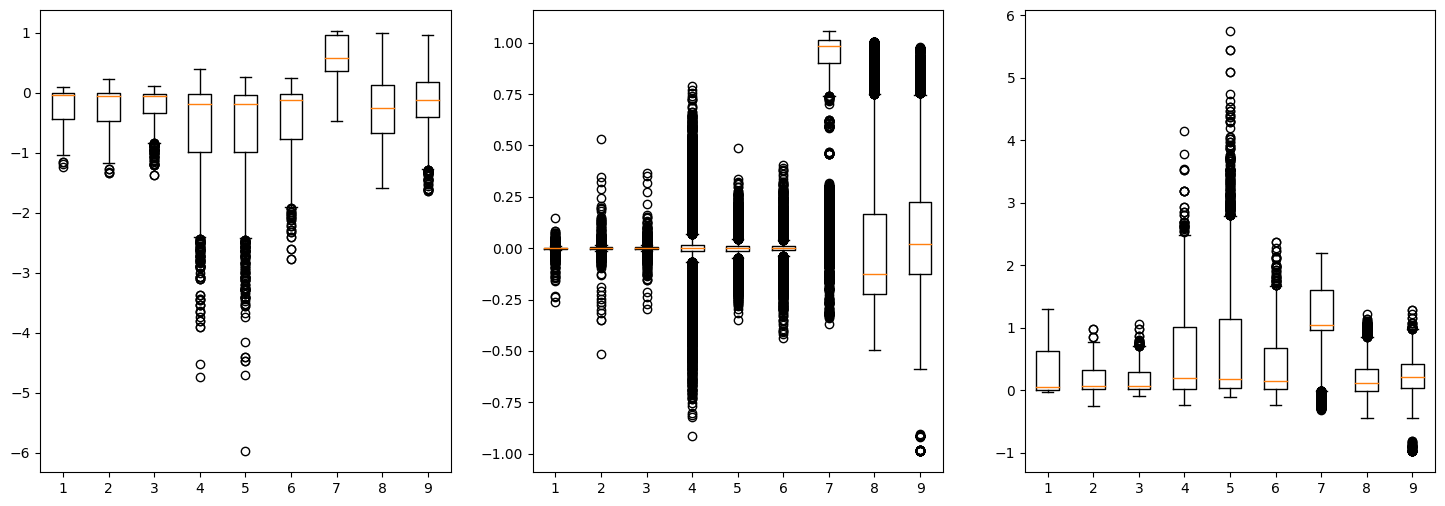

In [85]:
# Calculate the minimum per sample per feature
min_per_sample_per_feature = np.min(X_train_3D, axis=1)

# Calculate the maximum per sample per feature
max_per_sample_per_feature = np.max(X_train_3D, axis=1)

# Calculate the mean per sample per feature
mean_per_sample_per_feature = np.mean(X_train_3D, axis=1)

print(min_per_sample_per_feature[0])
print(mean_per_sample_per_feature[0])
print(max_per_sample_per_feature[0])

df1 = pd.DataFrame(min_per_sample_per_feature)
df2 = pd.DataFrame(mean_per_sample_per_feature)
df3 = pd.DataFrame(max_per_sample_per_feature)

# Plot a boxplot of the stats dataframes
print('\nmin - mean - max  plot')
fig, axes = plt.subplots(figsize=(18,6), ncols=3)
for i, df in enumerate([df1, df2, df3]):
    axes[i].boxplot(df)

---

#### Explore activity records per subject

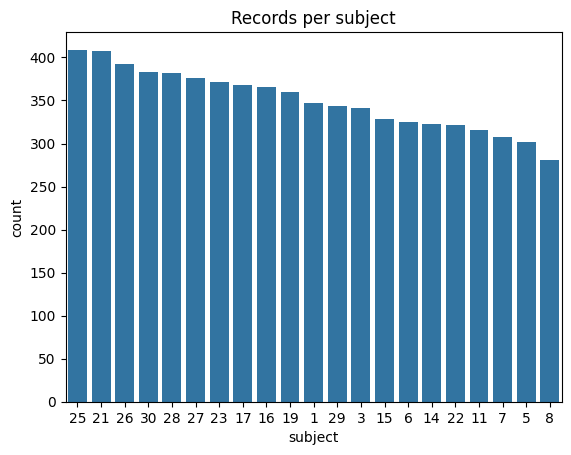

In [86]:
X_train_sub = X_train[0].copy()
X_train_sub['subject'] = subjects

plt.title("Records per subject")
sns.countplot(x='subject', data=X_train_sub, palette=[sns.color_palette()[0]], order=X_train_sub.subject.value_counts().index)
plt.show()

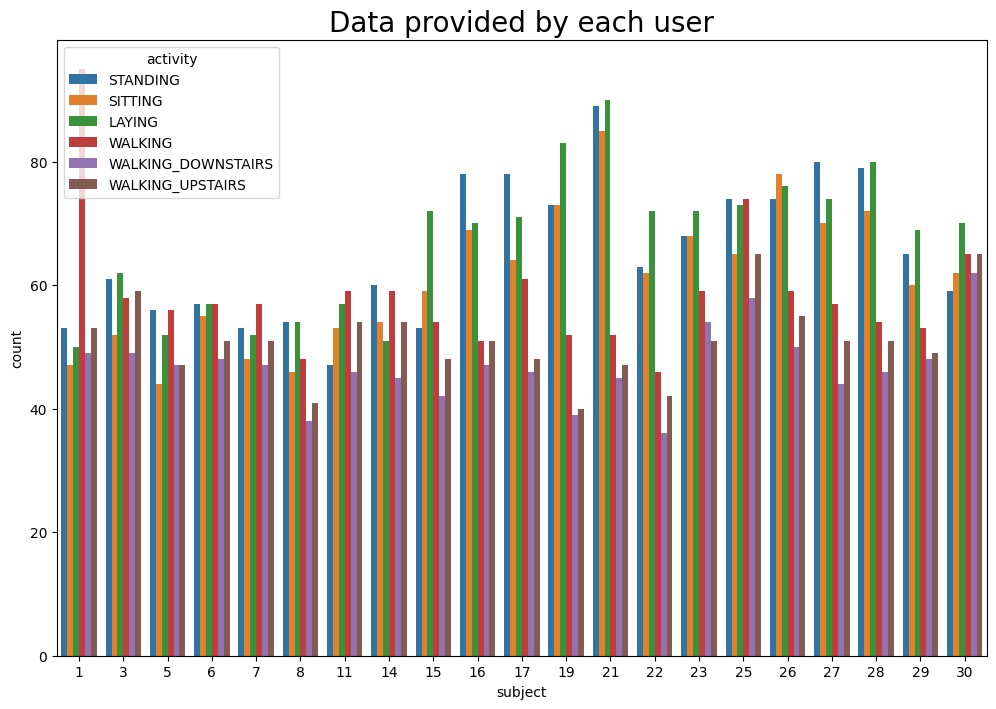

In [87]:
X_train_sub['activity'] = y_train_labels

plt.figure(figsize=(12,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject', hue='activity', data=X_train_sub)
plt.show()

---

### Use t-SNE and UMAP dimensionality reduction for multivariate time series data visualization

It can help understand which classes are easier to classify than others (e.g. laying or sitting VS. walking and walking downstairs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.064s...
[t-SNE] Computed neighbors for 7352 samples in 1.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.489409
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.020164
[t-SNE] KL divergence after 1000 iterations: 1.352530


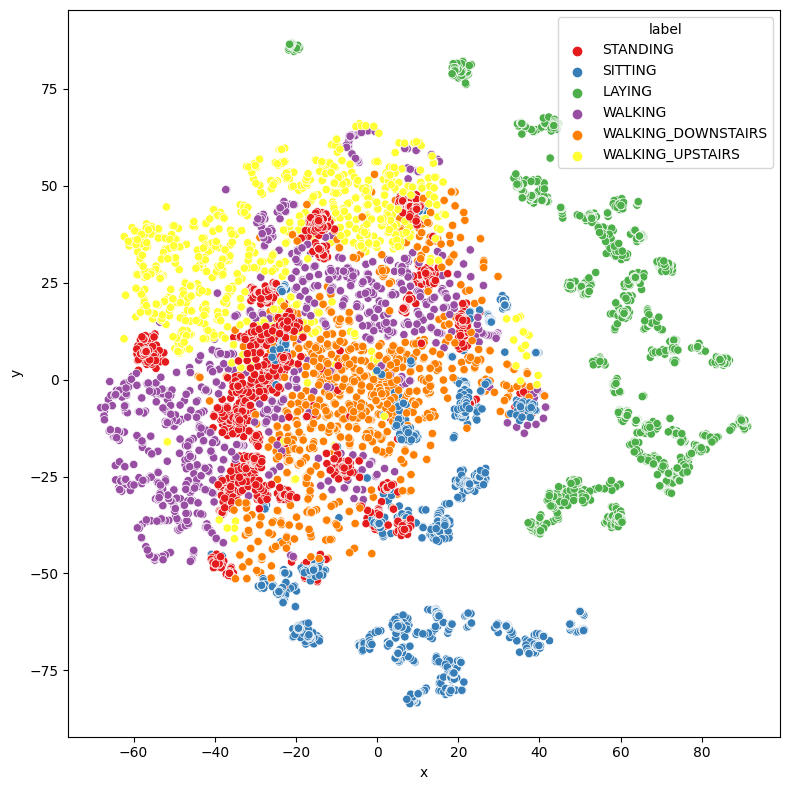

In [88]:
from sklearn.manifold import TSNE

X_train_ = pd.concat(X_train, axis=1, ignore_index=True)
X_reduced = TSNE(verbose=1, perplexity=30).fit_transform(X_train_)

x_tsne = pd.DataFrame({'x': X_reduced[:, 0], 'y': X_reduced[:, 1], 'label': y_train_labels})

plt.figure(figsize=(8,8))

sns.scatterplot(data=x_tsne, x='x', y='y', hue='label', palette="Set1")
plt.tight_layout()
plt.show()

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=1)
Construct fuzzy simplicial set
Thu Mar 23 20:15:30 2023 Finding Nearest Neighbors
Thu Mar 23 20:15:30 2023 Building RP forest with 9 trees
Thu Mar 23 20:15:30 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Thu Mar 23 20:15:30 2023 Finished Nearest Neighbor Search
Thu Mar 23 20:15:30 2023 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Mar 23 20:15:37 2023 Finished embedding


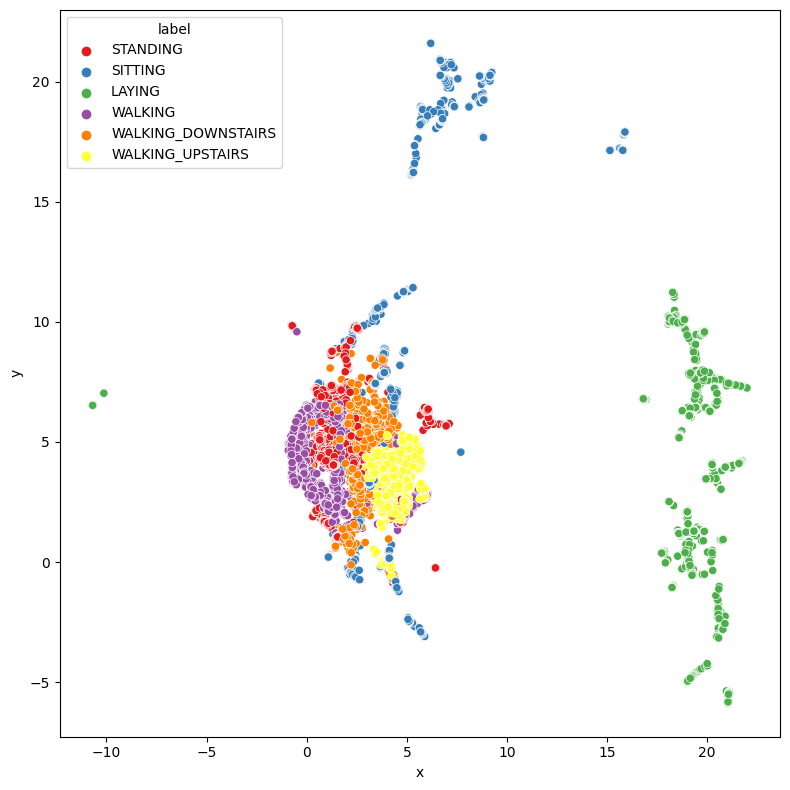

In [89]:
# UMAP is recommended VS. tSNE

import umap

X_reduced = umap.UMAP(n_components=2, verbose=1).fit_transform(X_train_)
x_tsne = pd.DataFrame({'x': X_reduced[:, 0], 'y': X_reduced[:, 1], 'label': y_train_labels})

plt.figure(figsize=(8,8))
sns.scatterplot(data=x_tsne, x='x', y='y', hue='label', palette="Set1")
plt.tight_layout()
plt.show()

---

## Train and Evaluate LSTM Model

In [90]:
# Create a model with an LSTM layer. The model takes in three arguments: timesteps, input_dim, and n_classes. 
# The LSTM layer has 128 units and the input shape is (timesteps, input_dim). 
# There is a dropout layer with a rate of 0.5 to reduce overfitting, followed by a dense layer with 64 units and ReLU activation. 
# Finally, there is a softmax layer with n_classes units. 
# The model is compiled with categorical cross-entropy loss, Adam optimizer, and accuracy metric.
#

from keras.optimizers import Adam


def create_model(timesteps, input_dim, n_classes):

    model = Sequential()
    
    # dropout layer with a rate of 0.5 to reduce overfitting
    # model.add(Bidirectional(LSTM(units=128, input_shape=(timesteps, input_dim))))
    model.add(LSTM(units=128, input_shape=(timesteps, input_dim)))
    
    model.add(Dropout(0.5))
    
    # dense layer with ReLu to interpret the features extracted by the LSTM hidden layer
    model.add(Dense(64, activation='relu'))

    # Softmax layer
    model.add(Dense(n_classes, activation='softmax'))   #activation='sigmoid'

    # opt = Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  #optimizer='rmsprop'
    return model


ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}



X stats - min-mean-max:
-15.109204909015652 -1.666207037198896e-16 14.034024510838867

X stats - min-mean-max:
-8.923682334549454 -7.737195033431886e-17 8.514580210317986
Epoch 1/20
230/230 [==============================] - ETA: 0s - loss: 0.8849 - accuracy: 0.6273
Epoch 1: val_accuracy improved from -inf to 0.73804, saving model to weights.best.hdf5
230/230 [==============================] - 20s 79ms/step - loss: 0.8849 - accuracy: 0.6273 - val_loss: 0.7012 - val_accuracy: 0.7380
Epoch 2/20
230/230 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8493
Epoch 2: val_accuracy improved from 0.73804 to 0.87004, saving model to weights.best.hdf5
230/230 [==============================] - 18s 77ms/step - loss: 0.4432 - accuracy: 0.8493 - val_loss: 0.4053 - val_accuracy: 0.8700
Epoch 3/20
230/230 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9272
Epoch 3: val_accuracy improved from 0.87004 to 0.87716, saving model to weights.best.hdf5
230/230

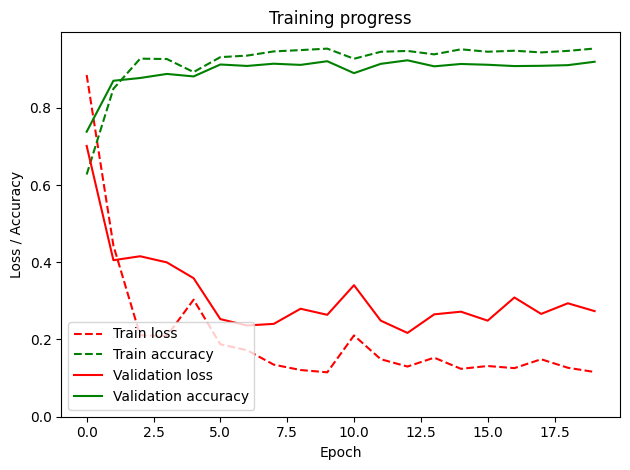

In [94]:
pd.set_option('expand_frame_repr', False)

def normalize_3D(X):        
    from sklearn import preprocessing as pre
    
    X_2D = X.reshape(-1, 1)
    X_norm_2D = pre.StandardScaler().fit_transform(X_2D)
    # X_norm_2d = pre.MinMaxScaler(feature_range=(-1,1)).fit_transform(X_2D)
    # Fit the scaler to the data and transform the data
    # X_normalized_2d = (X_2d - np.min(X_2d)) / (np.max(X_2d) - np.min(X_2d))

    # Reshape the data back to 3D
    X_normalized = X_norm_2D.reshape(X.shape)

    print('\nX stats - min-mean-max:')
    print(np.min(X_normalized), np.mean(X_normalized), np.max(X_normalized))

    return X_normalized

def _count_classes(y):
    return len(set([tuple(category) for category in y]))


_, _, X_train_3D, X_test_3D, y_train, y_test = load_data(normalize=True)

X_train_3D = normalize_3D(X_train_3D)
X_test_3D = normalize_3D(X_test_3D)

y_train = pd.get_dummies(y_train).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()


model = create_model(timesteps=len(X_train_3D[0]), input_dim=len(X_train_3D[0][0]), n_classes=_count_classes(y_train))


# checkpoint
filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)
callbacks_list = [checkpoint, es]

epochs = 20
batch_size = 32


history = model.fit(X_train_3D, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list, verbose=1, shuffle=True, validation_data=(X_test_3D, y_test))

print(model.summary())


# Plot training and validation accuracy and cross-entropy loss against a number of epochs –
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training progress")
plt.legend(loc='lower left')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
plt.ylim(0) 
plt.tight_layout()
plt.show()


### Evaluate the model

93/93 [==============================] - 3s 29ms/step

---
LSTM Accuracy score: 0.9230
---
93/93 [==============================] - 3s 29ms/step - loss: 0.2170 - accuracy: 0.9230

Test Accuracy : 0.9229725003242493
Test Loss : 0.21697869896888733


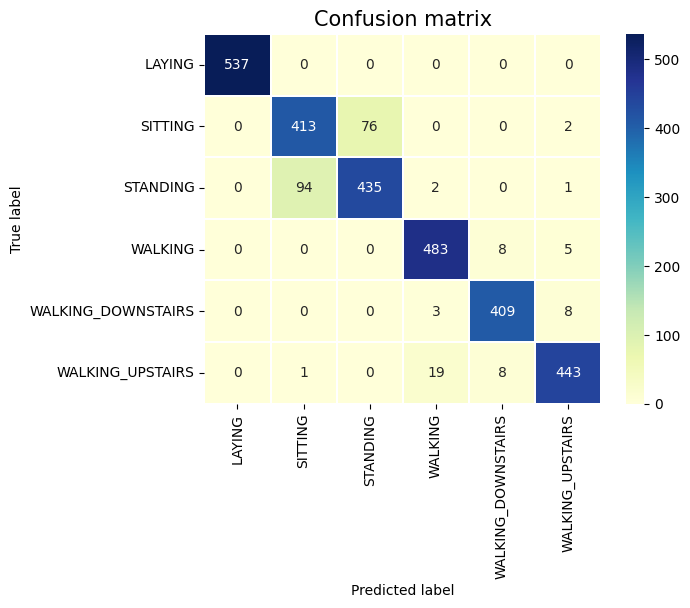


Confusion matrix:
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                                                                        
LAYING                 537        0         0        0                   0                 0
SITTING                  0      413        76        0                   0                 2
STANDING                 0       94       435        2                   0                 1
WALKING                  0        0         0      483                   8                 5
WALKING_DOWNSTAIRS       0        0         0        3                 409                 8
WALKING_UPSTAIRS         0        1         0       19                   8               443


In [95]:
def _confusion_matrix(y_true, y_pred):
    y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(y_true, axis=1)])
    y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(y_pred, axis=1)])
    
    cm = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Pred'])
    labels = list(cm.columns)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    # sns.heatmap(confusion_matrix, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
    sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt='d', cmap = 'YlGnBu')
    plt.title("Confusion matrix", fontsize = 15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return cm


# load best checkpoint weights 
model.load_weights('weights.best.hdf5')

# predict test data
y_pred_test = model.predict(X_test_3D)

# calculate the accuracy on test
y_pred_ = np.argmax(y_pred_test, axis=1)
y_test_ = np.argmax(y_test, axis=1)
print(f'\n---\nLSTM Accuracy score: {accuracy_score(y_test_, y_pred_):0.4f}')
print('---')

# calculate the loss and accuracy of the model
loss, accuracy = model.evaluate(X_test_3D, y_test, batch_size=batch_size, verbose=1)
print("\nTest Accuracy :", accuracy)
print("Test Loss :", loss)

# calculate the confusion matrix
cm = _confusion_matrix(y_test, y_pred_test)

print('\nConfusion matrix:')
print(cm)


From the confusion mattrix we see that our  Model is doing well for classes Laying, Walking, Standing, Walking_Downstairs and Walking_Upstairs but it is getting confused with Sitting.  
It may confuse mainly between Sitting or Standing, but also between Walking Upstairs or Walking Downstairs.

## Summary

The LSTM model was used to predict human activities based on accelerometer and gyroscope raw data. The model was trained on the Human Activity Recognition dataset,  
which contains data from 30 subjects performing 6 activities. 

The model achieved an accuracy score larger than 0.92 on the test data.  
This model can be used to predict the activity of a person based on the accelerometer and gyroscope data from their smartphone or wearable device.